In [4]:
import os
from track import *
from visualisations import plot_waveform_with_hot_cues
from tempo import adjust_tempo_and_analyze
from eq import create_eq_adjusted_tracks, create_eq_adjusted_tracks_treble, beats_to_seconds, normalize_audio_gain
from IPython.display import Audio
from mixing import combine_tracks
import soundfile as sf


def main():
    # specify your path
    path = "raw-wavs"

    raw_wav_files = []

    for file_name in os.listdir(path):
        if file_name.endswith('.wav'):
            raw_wav_files.append(os.path.join(path, file_name))

    raw_tracks = {}

    for wav_file in raw_wav_files:
        track_name = os.path.splitext(os.path.basename(wav_file))[0]
        track = Track(track_name, wav_file)
        raw_tracks[track_name] = track

    new_tracks = {}
    counter = {}

    for old_key, track in raw_tracks.items():
        new_key = old_key.split()[0]
        if new_key in counter:
            counter[new_key] += 1
            new_key = f"{new_key}{counter[new_key]}"
        else:
            counter[new_key] = 1
        new_tracks[new_key] = track

    tracks = new_tracks

    """
    for name, track in tracks.items():
        print(f"Preprocessing : {name}:")
        preprocess(track)
    """
    for name, track in tracks.items():
        if name == "Bours-" or name == "JKS":
            print(f"Preprocessing : {name}:")
            preprocess(track)

    a = tracks['Bours-']
    c = tracks['JKS']

    adjusted_ca = adjust_tempo_and_analyze("Bours-", "JKS", tracks)

    b = tracks['JKS_AT_149bpm']

    plot_waveform_with_hot_cues(a.audio, a.sr, a.cue_points_rms)
    plot_waveform_with_hot_cues(b.audio, b.sr, b.cue_points_rms)

    seconds = beats_to_seconds(a.tempo, 8)
    acue = a.cue_points_rms[4]
    bcue = b.cue_points_rms[2]
    bbass = b.cue_points_rms[4]
    abass = acue + (bbass - bcue - seconds)

    track1_eq, track2_eq = create_eq_adjusted_tracks(a.audio, b.audio, abass, bbass, a.sr)
    a_both_eq, b_both_eq = create_eq_adjusted_tracks_treble(track1_eq, track2_eq, bcue, bcue, 120, a.sr)

    combined = combine_tracks(a_both_eq, b_both_eq, acue, bcue, a.sr)
    combined_normalized = normalize_audio_gain(combined)

    sf.write('Boursy_mixed_with_JKS_at_149bpm.wav', combined_normalized, a.sr)
    return combined_normalized, a.sr

Preprocessing : Bours-:
Tempo : 149
Tempo: 149
Filtered Indices (RMS): [0, 78, 187, 206, 222, 270, 509, 538, 694, 702, 862]
Cue Points (RMS): [  0.42956915  32.066757    75.95247     83.61506     90.04698
 109.389206   205.6243     217.30394    280.12552    283.3531
 347.97424   ]
Beat series :  [1, 1, 8, 1]

Preprocessing : JKS:
Tempo : 146
Tempo: 146
Filtered Indices (RMS): [0, 363, 379, 411, 427, 523, 539, 555, 586, 597, 602, 618, 791]
Cue Points (RMS): [  0.44117913 150.2215     156.80435    169.94684    176.52971
 215.98041    222.55165    229.1345     242.06802    246.59592
 248.65088    255.22212    326.5306    ]
Beat series :  [1, 1, 3, 8]

1.0205479452054795
149.0
149
146
Tempo : 149
Tempo: 149
Filtered Indices (RMS): [0, 126, 363, 395, 491, 581, 586, 597, 602, 613, 618, 791, 821]
Cue Points (RMS): [  0.42956915  51.32771    147.19128    160.07837    198.7396
 235.17169    237.19183    241.61523    243.63538    248.05878
 250.06729    319.94775    332.02213   ]
Beat series :  

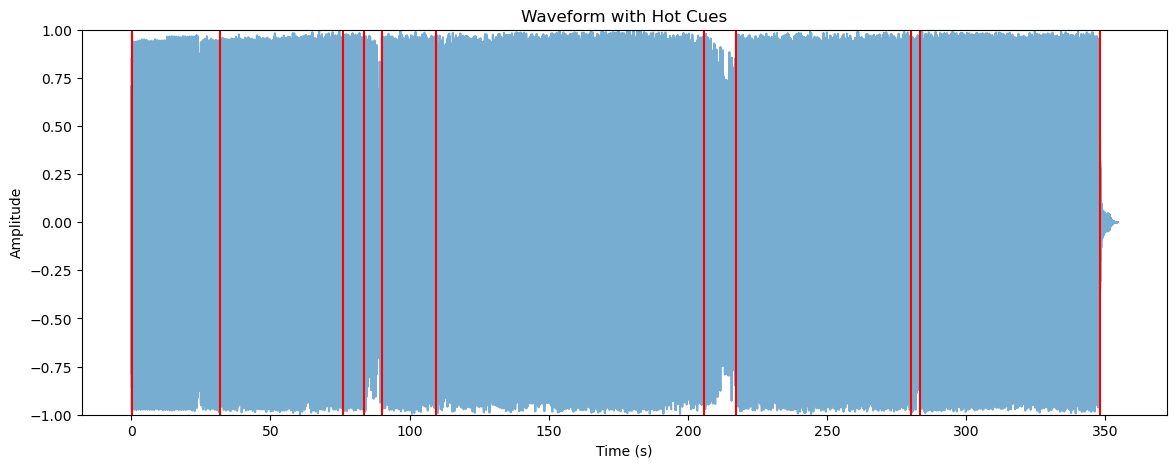

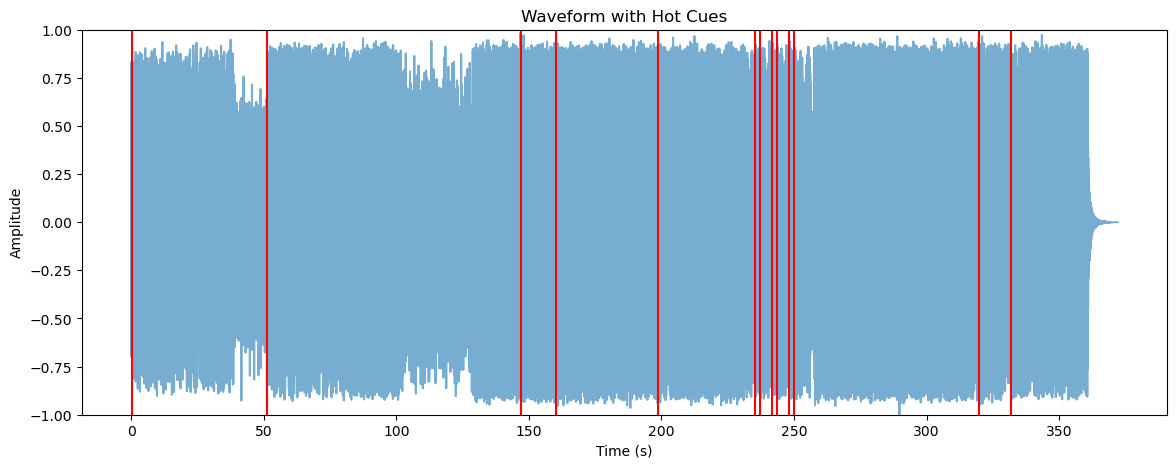

In [5]:
if __name__ == "__main__":
    combined_normalized, sr = main()